In [9]:
#AOI (River Delta) and Outlet point (Lat,Long)
from ipyleaflet import Map, DrawControl, LayersControl, basemaps
from ipywidgets import Output, VBox
from IPython.display import display

# Widgets to hold map and logs
log = Output()
m = Map(center=(44.92, 12.63), zoom=10, basemap=basemaps.OpenStreetMap.Mapnik)

# Storage
all_geometries = []

draw_control = DrawControl(
    polygon={"shapeOptions": {"color": "blue", "fillOpacity": 0.2}},
    marker={"shapeOptions": {"color": "red"}},
    rectangle={}, circle={}, circlemarker={}, polyline={},
    edit=True, remove=True
)

def handle_draw(target, action, geo_json):
    # append every new geometry
    all_geometries.append(geo_json["geometry"])
    # update only the log area
    with log:
        log.clear_output()
        print(f"{len(all_geometries)} geometry(ies) collected:")
        for i, geom in enumerate(all_geometries, 1):
            t = geom["type"]
            pts = len(geom["coordinates"][0]) if t == "Polygon" else ""
            print(f"  {i}. {t} {pts and f'with {pts} points'}")
        if any(g["type"]=="Point" for g in all_geometries) and any(g["type"]=="Polygon" for g in all_geometries):
            print(" Point (outlet) and a Polygon (AOI).  Ready to proceed.")

draw_control.on_draw(handle_draw)
m.add_control(draw_control)
m.add_control(LayersControl())

display(VBox([m, log]))







In [10]:

from shapely.geometry import Point, Polygon

# Point and  Polygon
point_geom    = next(g for g in all_geometries if g["type"] == "Point")
polygon_geom  = next(g for g in all_geometries if g["type"] == "Polygon")

# extract coordinates
outlet_lon, outlet_lat = point_geom["coordinates"]
aoi_coords = polygon_geom["coordinates"][0] 

print("Outlet coords:", outlet_lat, outlet_lon)
print("AOI polygon coords:", aoi_coords)

lat_point = outlet_lat
lon_point = outlet_lon
geometry_coords = aoi_coords  


Outlet coords: 44.954109 12.43515
AOI polygon coords: [[12.360992, 45.056061], [12.635651, 45.052181], [12.619171, 44.814967], [12.329407, 44.821786], [12.360992, 45.056061]]


In [8]:
import os
import xarray as xr
import pandas as pd
import numpy as np
from geopy.distance import geodesic


lat_point = outlet_lat
lon_point = outlet_lon


files = [
    "/home/michelangelo/data_discharge_2018.grib",
    "/home/michelangelo/data_discharge_2019.grib",
    "/home/michelangelo/data_discharge_2020.grib",
    "/home/michelangelo/data_discharge_2021.grib",
    "/home/michelangelo/data_discharge_2022.grib",
    "/home/michelangelo/data_discharge_2023.grib2",
]

# Get nearest valid point (nearest interpolation)
def get_nearest_valid(ds, lat, lon, var="dis24"):
    data = ds[var].isel(time=0)
    valid = data.where(~np.isnan(data), drop=True)
    nearest = valid.sel(latitude=lat, longitude=lon, method="nearest")
    return float(nearest.latitude), float(nearest.longitude)


ds_ref = xr.open_dataset(files[0], engine="cfgrib", filter_by_keys={"shortName": "dis24"}, backend_kwargs={"indexpath": ""})
valid_lat, valid_lon = get_nearest_valid(ds_ref, lat_point, lon_point)
ds_ref.close()

print(f"Nearest valid point to ({lat_point}, {lon_point}) is ({valid_lat}, {valid_lon})")
print(f"Distance: {geodesic((lat_point, lon_point), (valid_lat, valid_lon)).km:.2f} km")


series_list = []

for f in files:
    try:
        ds = xr.open_dataset(f, engine="cfgrib", filter_by_keys={"shortName": "dis24"}, backend_kwargs={"indexpath": ""})
        da = ds["dis24"].sel(latitude=valid_lat, longitude=valid_lon, method="nearest")

        if np.isnan(da.values).all():
            print(f"File {f} has only NaNs. Skipped.")
            ds.close()
            continue

        time_index = pd.to_datetime(ds["time"].values)
        s = pd.Series(da.values, index=time_index).dropna()
        series_list.append(s)
        ds.close()

    except Exception as e:
        print(f"Error processing {f}: {e}")


if not series_list:
    raise ValueError("No valid discharge data found.")

discharge = pd.concat(series_list)
discharge = discharge[~discharge.index.duplicated()].sort_index().asfreq("D")

print(f"Discharge series ready: {len(discharge)} daily values from {discharge.index.min().date()} to {discharge.index.max().date()}")







/home/michelangelo/miniconda3/envs/master_thesis/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Nearest valid point to (44.956538, 12.416782) is (44.97500000000255, 12.425000000006724)
Distance: 2.15 km


/home/michelangelo/miniconda3/envs/master_thesis/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/home/michelangelo/miniconda3/envs/master_thesis/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/home/michelangelo/miniconda3/envs/master_thesis/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to Tr

Discharge series ready: 2191 daily values from 2018-01-01 to 2023-12-31


In [9]:
# Block Maxima Method
from pyextremes import EVA
model = EVA(discharge)
model.get_extremes(method="BM", block_size=pd.Timedelta(days=30))
model.fit_model()

summary = model.get_summary(return_period=[1], alpha=0.95, n_samples=12)
threshold = float(summary.loc[1, 'return value'])

print(f"Computed threshold (TR = 30 days): {threshold:.2f} m³/s")

Computed threshold (TR = 30 days): 4557.84 m³/s


In [4]:
#Identification treshold in 2023
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os

file_2023 = "/home/michelangelo/data_discharge_2023.grib2"

ds = xr.open_dataset(
    file_2023,
    engine="cfgrib",
    filter_by_keys={"shortName": "dis24"},
    backend_kwargs={"indexpath": ""},
    chunks={"time": 50}
)

da = ds["dis24"].sel(latitude=valid_lat, longitude=valid_lon, method="nearest")
series_2023 = da.to_series().dropna()
series_2023 = series_2023[~series_2023.index.duplicated()].asfreq("D")
ds.close()
exceed_dates = series_2023[series_2023 > threshold].index

if exceed_dates.empty:
    print("The threshold was not exceeded in 2023.")
else:
    event_date = exceed_dates.min()
    print(f"When: {event_date.date()}")





/home/michelangelo/miniconda3/envs/master_thesis/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


When: 2023-11-03


/tmp/ipykernel_87345/4139538400.py:12: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis="x", nbins=12)


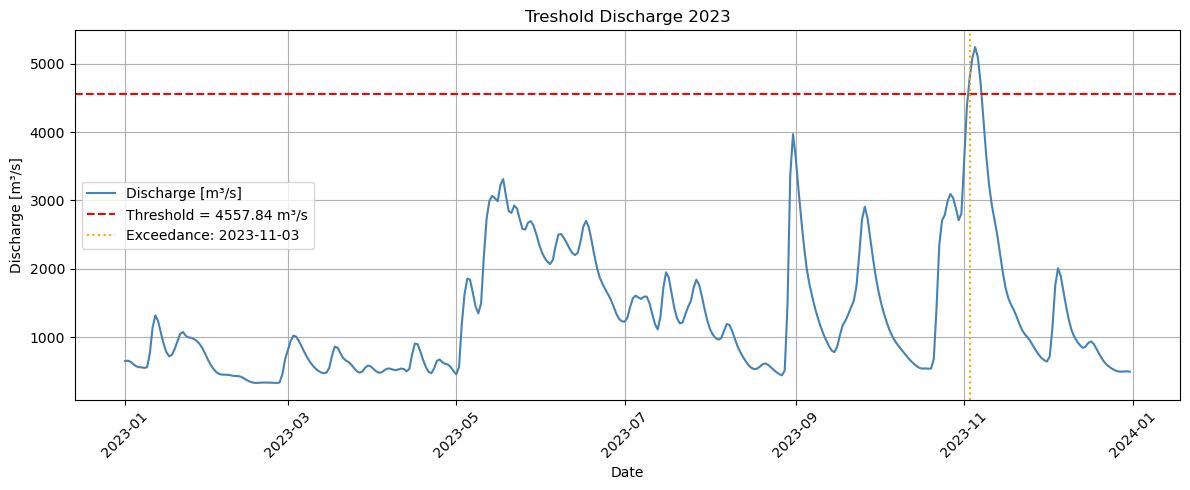

In [5]:
# Plot treshold 2023
plt.figure(figsize=(12, 5))
plt.plot(series_2023.index, series_2023.values, label="Discharge [m³/s]", color="steelblue")
plt.axhline(threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.2f} m³/s")
if event_date:
    plt.axvline(event_date, color="orange", linestyle=":", label=f"Exceedance: {event_date.date()}")

plt.title("Treshold Discharge 2023")
plt.xlabel("Date")
plt.ylabel("Discharge [m³/s]")
plt.xticks(rotation=45)
plt.locator_params(axis="x", nbins=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#Downloading Sentinel-2 images using event date as a filter
import ee
import datetime
from ee import batch
ee.Initialize()

if event_date is None:
    raise SystemExit("No event date. Aborting downloads.")


ggeometry = ee.Geometry.Polygon(geometry_coords)

sample = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(ggeometry).first()
proj = sample.select("B2").projection().getInfo()

drive_folder = "Lorie_River"

offsets = list(range(-10, 11))  # -10, ..., 0, ..., +10

print(f"Downloading images for event {event_date.date()} with +/-10 days")
for off in offsets:
    target = event_date + datetime.timedelta(days=off)
    next_day = target + datetime.timedelta(days=1)
    coll = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
            .filterDate(target.strftime("%Y-%m-%d"), next_day.strftime("%Y-%m-%d"))
            .filterBounds(ggeometry)
            .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 40)))
    best = coll.sort("CLOUDY_PIXEL_PERCENTAGE").first()
    info = best.getInfo()
    if info and 'id' in info:
        img = best.select([
            'B1','B2','B3','B4','B5','B6',
            'B7','B8','B8A','B9','B11','B12'
        ]).clip(ggeometry)
 
        date_str = target.strftime('%Y_%m_%d')
        task = batch.Export.image.toDrive(
            image=img,
            description=date_str,
            folder=drive_folder,
            fileNamePrefix=date_str,
            fileFormat='GeoTIFF',  # ensure TIFF format
            region=ggeometry,
            crs=proj['crs'],
            crsTransform=proj['transform'],
            maxPixels=1e13
        )
        task.start()
        print(f"  ✔ Offset {off:+d}: downloaded for {target.date()} as {date_str}.tif")
    else:
        print(f"  – Offset {off:+d}: no valid scene on {target.date()}")

print("Download block completed.")




  – Offset -10: no valid scene on 2023-10-24
  – Offset -9: no valid scene on 2023-10-25
  – Offset -8: no valid scene on 2023-10-26
  ✔ Offset -7: downloaded for 2023-10-27 as 2023_10_27.tif
  – Offset -6: no valid scene on 2023-10-28
  – Offset -5: no valid scene on 2023-10-29
  – Offset -4: no valid scene on 2023-10-30
  – Offset -3: no valid scene on 2023-10-31
  – Offset -2: no valid scene on 2023-11-01
  – Offset -1: no valid scene on 2023-11-02
  – Offset +0: no valid scene on 2023-11-03
  ✔ Offset +1: downloaded for 2023-11-04 as 2023_11_04.tif
  – Offset +2: no valid scene on 2023-11-05
  – Offset +3: no valid scene on 2023-11-06
  – Offset +4: no valid scene on 2023-11-07
  – Offset +5: no valid scene on 2023-11-08
  – Offset +6: no valid scene on 2023-11-09
  – Offset +7: no valid scene on 2023-11-10
  ✔ Offset +8: downloaded for 2023-11-11 as 2023_11_11.tif
  – Offset +9: no valid scene on 2023-11-12
  – Offset +10: no valid scene on 2023-11-13
Download block completed.


In [40]:
#  Marinedebris detector unet  ++ no label refinement
import os
import numpy as np
import rasterio
import torch
from tqdm import tqdm
from marinedebrisdetector.main_cli import MarineDebrisDetector

@torch.no_grad()
def sliding_window_inference(image_path, detector, tile_size=256, stride=64, device="cuda"):
    with rasterio.open(image_path) as src:
        img = src.read()  # (bands, H, W)
        profile = src.profile
        h, w = img.shape[1], img.shape[2]

   
    img = img.astype(np.float32) / 10000.0


    pred_sum = np.zeros((h, w), dtype=np.float32)
    pred_count = np.zeros((h, w), dtype=np.float32)

    # Sliding window
    for y in tqdm(range(0, h - tile_size + 1, stride), desc="Sliding"):
        for x in range(0, w - tile_size + 1, stride):
            patch = img[:, y:y+tile_size, x:x+tile_size]
            input_tensor = torch.from_numpy(patch).unsqueeze(0).to(device)  # (1, C, H, W)

            score, _ = detector(input_tensor)
            pred = score.squeeze().cpu().numpy()  # (H, W)

            pred_sum[y:y+tile_size, x:x+tile_size] += pred
            pred_count[y:y+tile_size, x:x+tile_size] += 1

  
    final_pred = pred_sum / (pred_count + 1e-8)
    return final_pred, profile

In [41]:
import glob
class Args:
    def __init__(self):
        self.model = "unetpp_no_label_refinement"
        self.device = "cuda"
        self.ensemble = False
        self.test_time_augmentation = False
        self.pretrained = False
        self.model_path = None
        self.seed = "1"

args = Args()
detector = MarineDebrisDetector(args)
detector.model.eval().to(args.device)


folder = "/home/michelangelo/PO_river"
tif_paths = sorted(glob.glob(os.path.join(folder, "*.tif")))
tif_paths = [p for p in tif_paths if not p.endswith("_prediction.tif") and not p.endswith("_sliding_prediction.tif")]


for image_path in tif_paths:
    print(f"\inference: {image_path}")
    pred, profile = sliding_window_inference(image_path, detector, tile_size=256, stride=64, device="cuda")

    output_path = image_path.replace(".tif", "_sliding_prediction.tif")

    profile.update({
        "count": 1,
        "dtype": "float32",
        "height": pred.shape[0],
        "width": pred.shape[1]
    })

    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(pred.astype(np.float32), 1)

    print(f"prediction: {output_path}")

Loading weights from: /home/michelangelo/marinedebrisdetector/marinedebrisdetector/data/unet++1/epoch=54-val_loss=0.50-auroc=0.987.ckpt
\inference: /home/michelangelo/PO_river/sentinelimage_2023-06-24_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.31it/s]


prediction: /home/michelangelo/PO_river/sentinelimage_2023-06-24_PO_sliding_prediction.tif
\inference: /home/michelangelo/PO_river/sentinelimage_2023-06-29_2_PO.tif


Sliding: 100%|██████████| 60/60 [00:44<00:00,  1.34it/s]


prediction: /home/michelangelo/PO_river/sentinelimage_2023-06-29_2_PO_sliding_prediction.tif
\inference: /home/michelangelo/PO_river/sentinelimage_2023-07-02_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.33it/s]


prediction: /home/michelangelo/PO_river/sentinelimage_2023-07-02_PO_sliding_prediction.tif
\inference: /home/michelangelo/PO_river/sentinelimage_2023-10-02_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.33it/s]


prediction: /home/michelangelo/PO_river/sentinelimage_2023-10-02_PO_sliding_prediction.tif
\inference: /home/michelangelo/PO_river/sentinelimage_2023-10-07_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.33it/s]


prediction: /home/michelangelo/PO_river/sentinelimage_2023-10-07_PO_sliding_prediction.tif
\inference: /home/michelangelo/PO_river/sentinelimage_2023-11-04_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.33it/s]


prediction: /home/michelangelo/PO_river/sentinelimage_2023-11-04_PO_sliding_prediction.tif
\inference: /home/michelangelo/PO_river/sentinelimage_2023-11-11_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.33it/s]


prediction: /home/michelangelo/PO_river/sentinelimage_2023-11-11_PO_sliding_prediction.tif
\inference: /home/michelangelo/PO_river/sentinelimage_2023-11-26_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.32it/s]


prediction: /home/michelangelo/PO_river/sentinelimage_2023-11-26_PO_sliding_prediction.tif
\inference: /home/michelangelo/PO_river/sentinelimage_2023-12-16_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.32it/s]


prediction: /home/michelangelo/PO_river/sentinelimage_2023-12-16_PO_sliding_prediction.tif
\inference: /home/michelangelo/PO_river/sentinelimage_2023-12-24_PO.tif


Sliding: 100%|██████████| 60/60 [00:45<00:00,  1.32it/s]


prediction: /home/michelangelo/PO_river/sentinelimage_2023-12-24_PO_sliding_prediction.tif


\ treshold: 0.3183



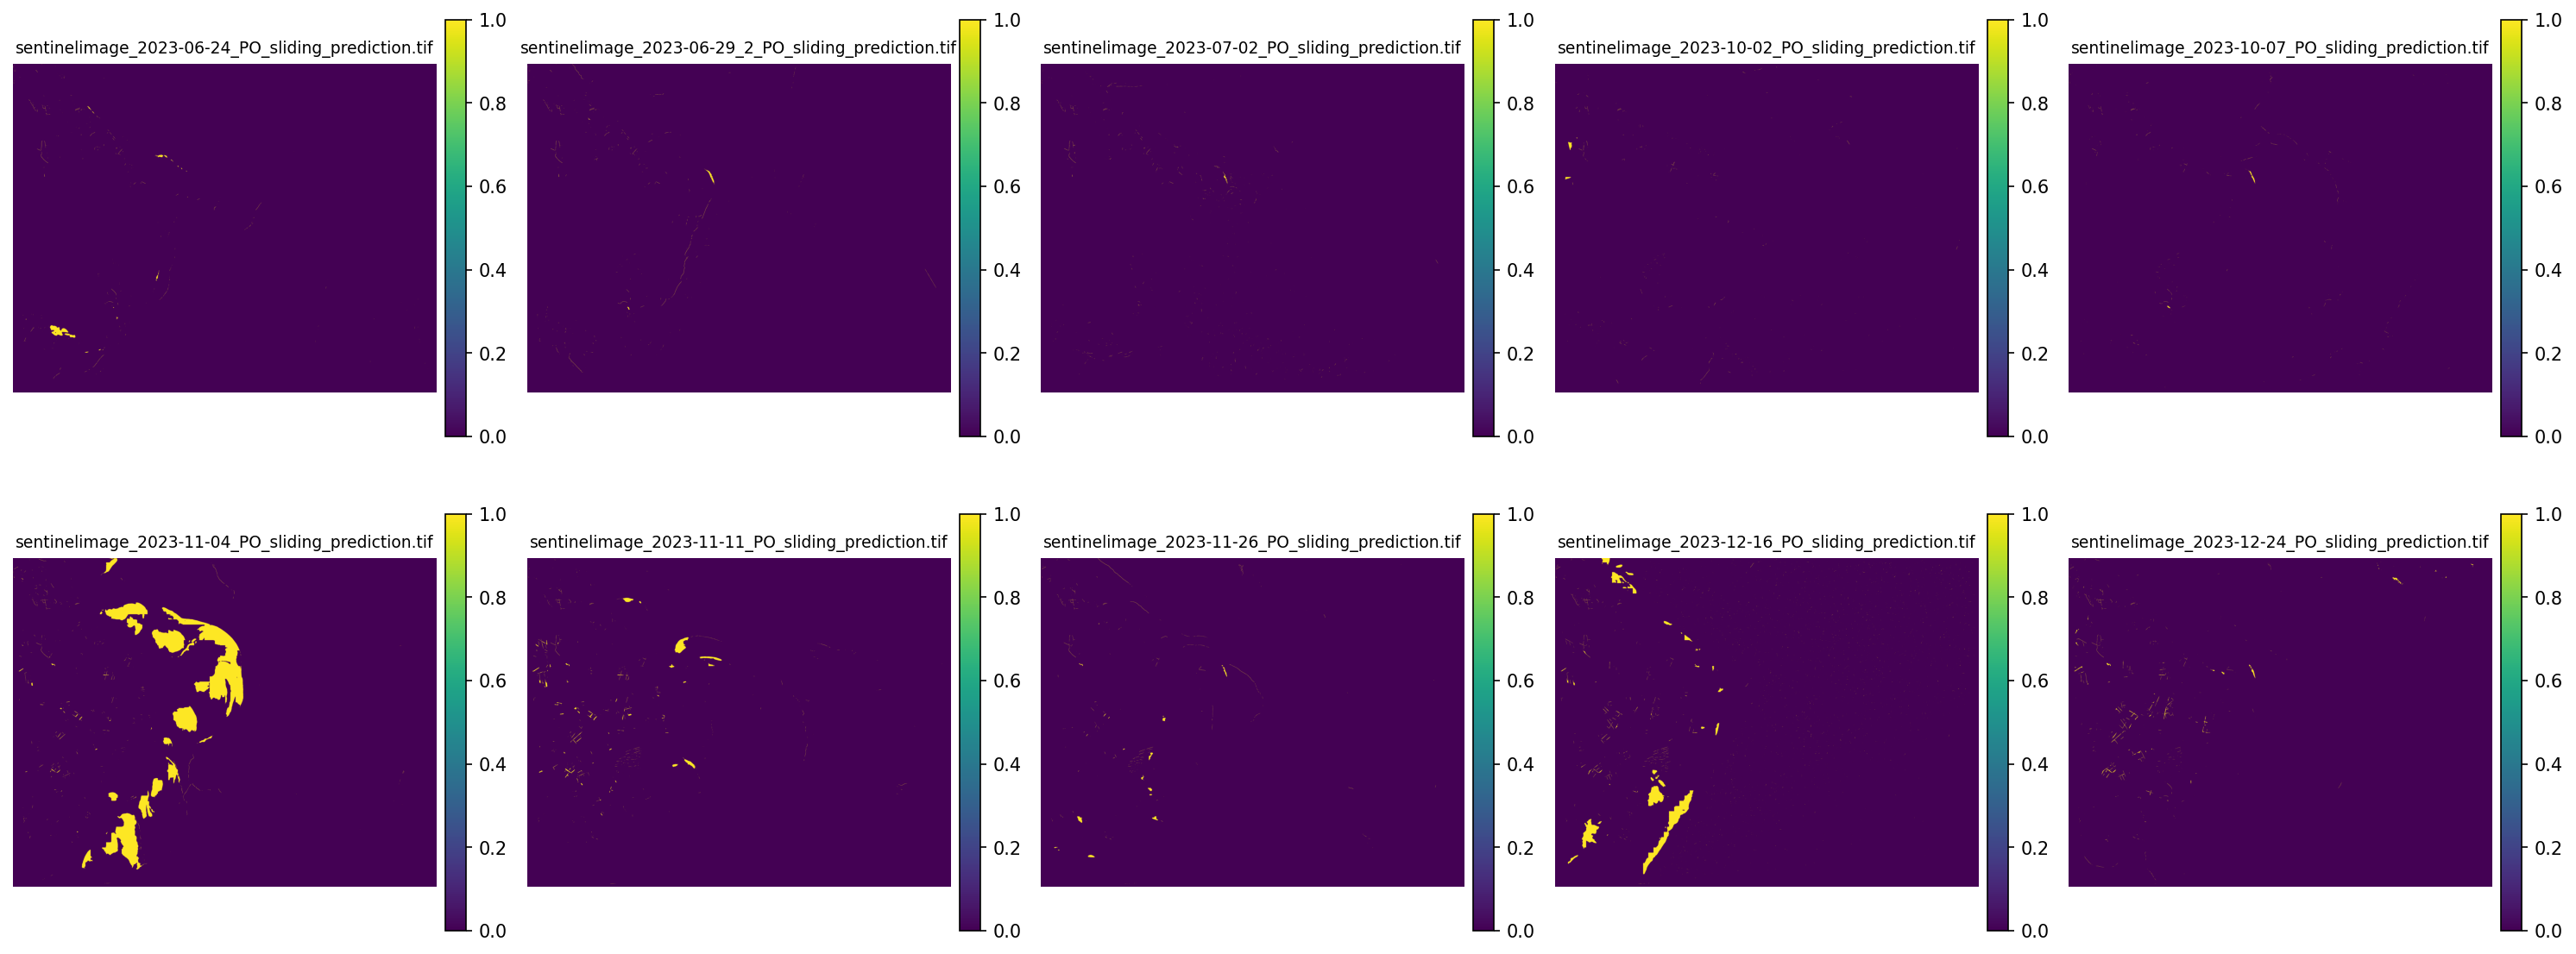

In [15]:
# Activation maps binarized unet++ no label refinement
import os
import glob
import rasterio
import numpy as np
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt


folder = "/home/michelangelo/Sentinel_normalize"
prediction_paths = sorted(glob.glob(os.path.join(folder, "*_prediction.tif")))


all_pixels = []
for path in prediction_paths:
    with rasterio.open(path) as src:
        img = src.read(1).astype(np.float32)
    all_pixels.append(img.flatten())
all_pixels = np.concatenate(all_pixels)


global_thr = threshold_otsu(all_pixels)
print(f"\ treshold: {global_thr:.4f}\n")

binary_images = []
filenames = []
for path in prediction_paths:
    with rasterio.open(path) as src:
        img = src.read(1).astype(np.float32)
    bin_img = (img > global_thr).astype(np.uint8)
    binary_images.append(bin_img)
    filenames.append(os.path.basename(path))


n = len(binary_images)
ncols = 5
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), dpi=150)
axes = axes.flatten()

for ax, bin_img, fname in zip(axes, binary_images, filenames):
    im = ax.imshow(bin_img, cmap="viridis", vmin=0, vmax=1)
    ax.set_title(fname, fontsize=9)
    ax.axis("off")
    fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.02)


for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [5]:
#FDI estimation
import os
import numpy as np
import rasterio
from skimage.filters import threshold_otsu
from pathlib import Path
import matplotlib.pyplot as plt

def compute_fdi(tiff_path,
                band_nir=8, band_red=4, band_swir1=11,
                lambda_nir=832.9e-9, lambda_red=664.8e-9, lambda_swir1=1612.05e-9,
                band_blue=2, blue_threshold=2000,
                band_green=3, water_threshold=0):
    with rasterio.open(tiff_path) as src:
        nir   = src.read(band_nir).astype(np.float32)
        red   = src.read(band_red).astype(np.float32)
        swir1 = src.read(band_swir1).astype(np.float32)
        blue  = src.read(band_blue).astype(np.float32)
        green = src.read(band_green).astype(np.float32)
    factor     = 10 * (lambda_nir - lambda_red) / (lambda_swir1 - lambda_red)
    nir_prime  = red + (swir1 - red) * factor
    fdi        = nir - nir_prime
    fdi[blue   > blue_threshold] = np.nan
    denom      = green + nir
    with np.errstate(divide='ignore', invalid='ignore'):
        ndwi = (green - nir) / denom
    ndwi[~np.isfinite(ndwi)] = np.nan
    fdi[ndwi   < water_threshold] = np.nan
    return fdi

tiff_dir = Path("/home/michelangelo/PO_river")
all_files = sorted([str(p) for p in tiff_dir.glob("*.tif") if "_prediction" not in p.name])


# Normalize
normalized_fdi_list = []
for path in all_files:
    fdi    = compute_fdi(path)
    m      = np.nanmax(fdi)
    fdi_n  = (fdi / m) if np.isfinite(m) and m!=0 else np.full_like(fdi, np.nan)
    normalized_fdi_list.append(fdi_n)
for f in all_files:
    print("  •", os.path.basename(f))


nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()
high_fdi_threshold = 0.0
for i, tiff_path in enumerate(all_files):
    fdi = compute_fdi(tiff_path)
    max_val = np.nanmax(fdi)
    fdi_normalized = fdi / max_val
    fdi_high = np.where(fdi_normalized >= high_fdi_threshold, fdi_normalized, np.nan)
    im = axes[i].imshow(fdi_high, cmap= 'magma')
    axes[i].set_title(os.path.basename(tiff_path))
    axes[i].axis('off')
    fig.colorbar(im, ax=axes[i], orientation='vertical')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show() 

  • sentinelimage_2023-06-24_PO.tif
  • sentinelimage_2023-06-29_2_PO.tif
  • sentinelimage_2023-07-02_PO.tif
  • sentinelimage_2023-10-02_PO.tif
  • sentinelimage_2023-10-07_PO.tif
  • sentinelimage_2023-11-04_PO.tif
  • sentinelimage_2023-11-11_PO.tif
  • sentinelimage_2023-11-26_PO.tif
  • sentinelimage_2023-12-16_PO.tif
  • sentinelimage_2023-12-24_PO.tif


treshold: 0.1694


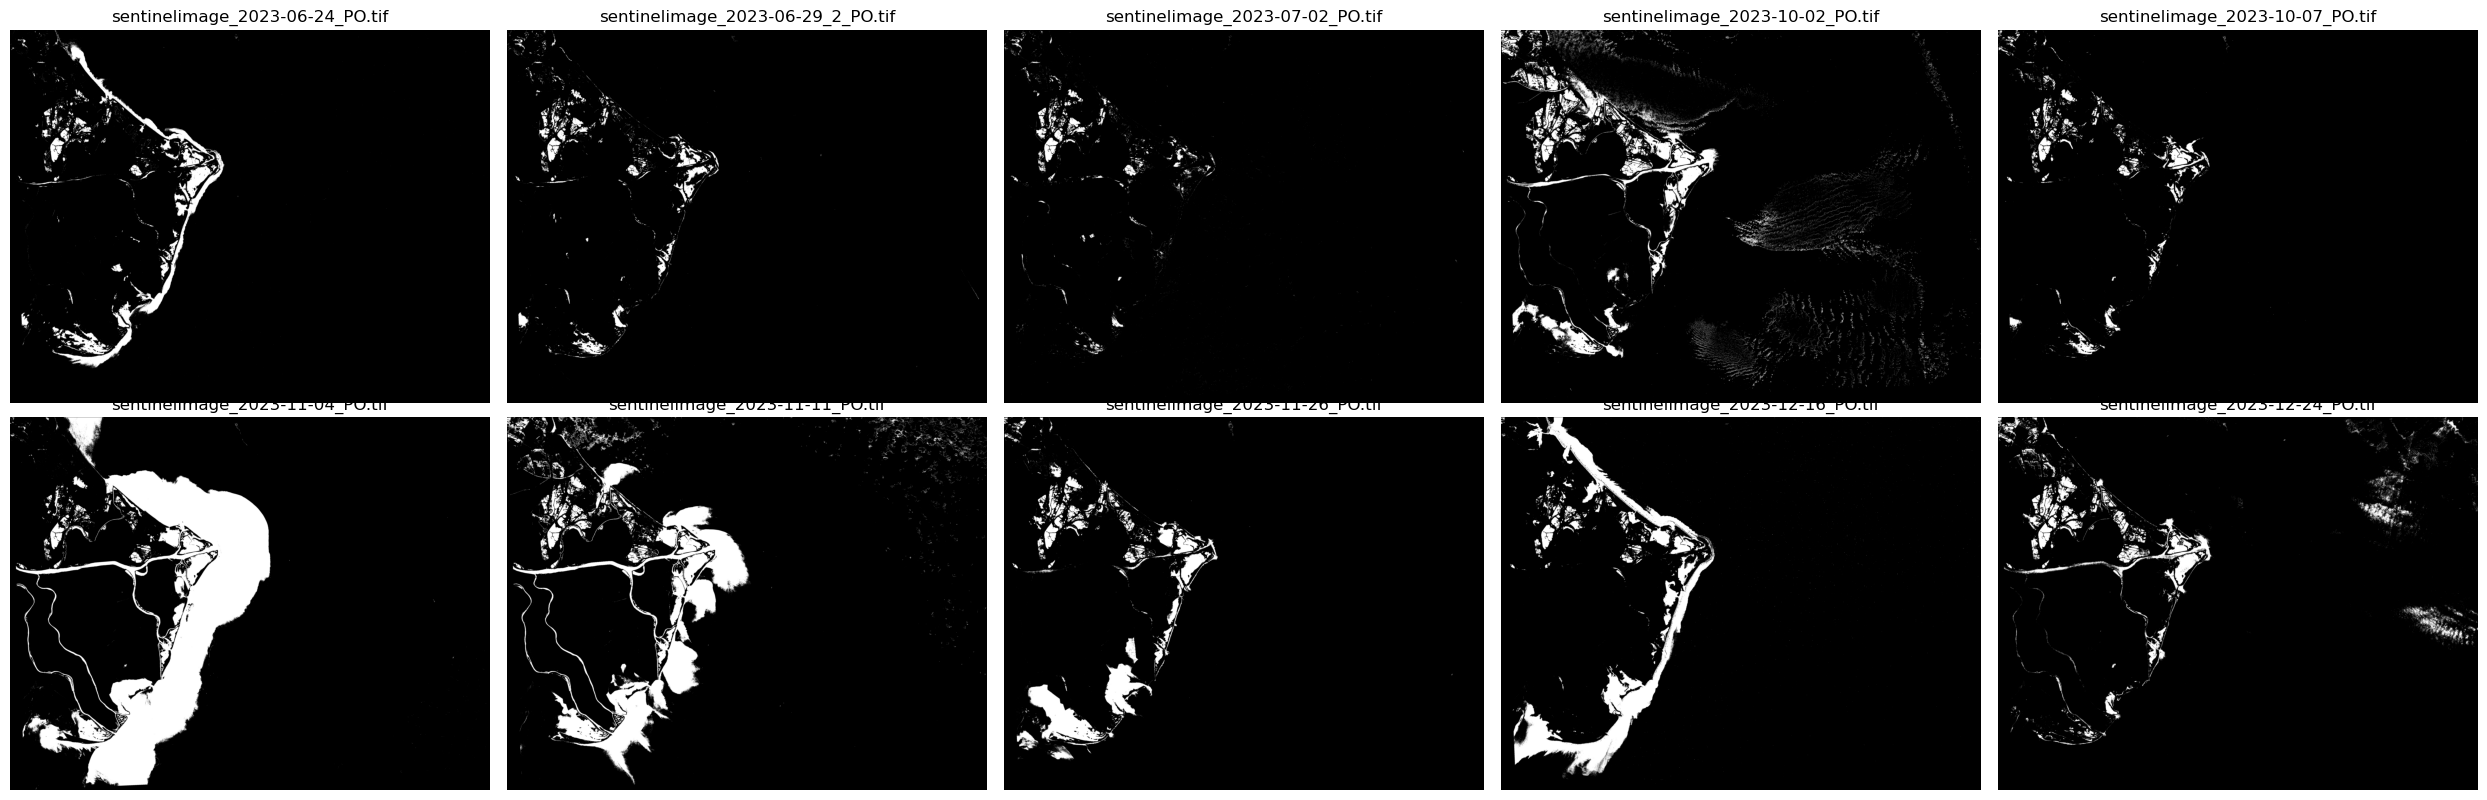

In [4]:
#FDI Binarized
import os
import numpy as np
import rasterio
from skimage.filters import threshold_otsu
from pathlib import Path
import matplotlib.pyplot as plt



tiff_dir = Path("/home/michelangelo/PO_river")
all_files = sorted([str(p) for p in tiff_dir.glob("*.tif") if "_prediction" not in p.name])


normalized_fdi_list = []
all_values = []

for path in all_files:
    fdi = compute_fdi(path)
    m = np.nanmax(fdi)
    fdi_n = (fdi / m) if np.isfinite(m) and m != 0 else np.full_like(fdi, np.nan)
    normalized_fdi_list.append(fdi_n)

    vals = fdi_n[~np.isnan(fdi_n)].ravel()
    if vals.size > 0:
        all_values.append(vals)


all_values = np.concatenate(all_values)


global_thresh = threshold_otsu(all_values)
print(f"treshold: {global_thresh:.4f}")


nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for i, fdi_norm in enumerate(normalized_fdi_list):
   
    bin_map = np.where(fdi_norm >= global_thresh, 1, 0)
    im = axes[i].imshow(bin_map, cmap='gray')
    axes[i].set_title(os.path.basename(all_files[i]))
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Trovati 10 file pred.
Stack shape: (4069, 5238, 10) (H, W, T)


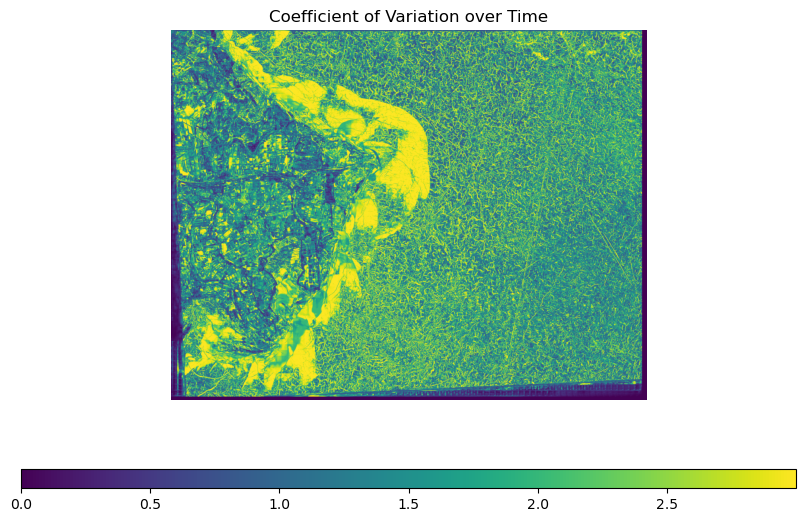

In [13]:
#Coefficent of variation for change detection
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import glob

input_folder = "/home/michelangelo/Sentinel_normalize"  
file_paths = sorted(glob.glob(os.path.join(input_folder, "*_prediction.tif")))

print(f"Trovati {len(file_paths)} file pred.")
assert len(file_paths) > 0, "⚠️ Nessun file *_prediction.tif trovato!"


stack = np.stack([rasterio.open(f).read(1) for f in file_paths], axis=2)
print(f"Stack shape: {stack.shape} (H, W, T)")

mean_stack = np.mean(stack, axis=2)
std_stack = np.std(stack, axis=2)


coeff_var_time = np.divide(std_stack, mean_stack,
                           out=np.zeros_like(std_stack),
                           where=mean_stack != 0)

plt.figure(figsize=(10, 6))
plt.imshow(coeff_var_time, cmap='viridis')  # nessuna normalizzazione
plt.title("Coefficient of Variation over Time")
plt.colorbar(orientation="horizontal", fraction=0.05, aspect=40)
plt.axis("off")
plt.show()

Clipping CV ai percentili 5–95: 1.061 – 2.995


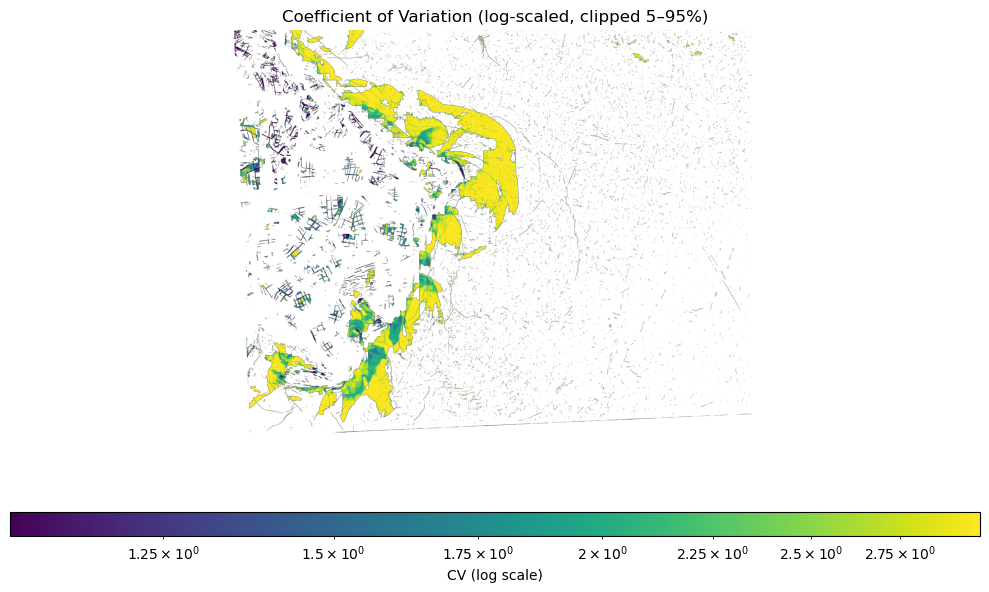

In [16]:
#CV masking
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import glob
from matplotlib.colors import LogNorm

# 1) Carica stack
input_folder = "/home/michelangelo/Sentinel_normalize"  
paths = sorted(glob.glob(os.path.join(input_folder, "*_prediction.tif")))
stack = np.stack([rasterio.open(p).read(1).astype(np.float32) for p in paths], axis=2)

mean_stack = stack.mean(axis=2)
std_stack  = stack.std(axis=2)
cv = np.divide(std_stack, mean_stack,
               out=np.zeros_like(std_stack),
               where=mean_stack!=0)

# Masking pixel with low mean
mean_thresh = 0.01  # adjust based on stack's values
cv_masked = np.ma.masked_where(mean_stack < mean_thresh, cv)

# Percintile for clipping
p5, p95 = np.percentile(cv_masked.compressed(), [5, 95])
print(f"Clipping CV ai percentili 5–95: {p5:.3f} – {p95:.3f}")

# Plot in log 
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
im = ax.imshow(cv_masked + 1e-6,  # evita zero log
               cmap='viridis',
               norm=LogNorm(vmin=p5, vmax=p95))
ax.set_title("Coefficient of Variation (log-scaled, clipped 5–95%)")
ax.axis('off')


cbar = fig.colorbar(im, ax=ax, orientation="horizontal", fraction=0.05, aspect=40)
cbar.set_label("CV (log scale)")

plt.tight_layout()
plt.show()


In [ ]:
#Statistic on binarize prediction maps
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




# 2) Estrazione delle date dai file
dates = []
for path in all_prediction_files:
    m = re.search(r"(\d{4}-\d{2}-\d{2})", os.path.basename(path))
    dates.append(pd.to_datetime(m.group(1)) if m else pd.NaT)

# 3) Calcolo conteggi, proporzioni e accumulo stats
stats = []
for date, bm in zip(dates, binarized_prediction_maps):
    flat  = bm.ravel()
    total = flat.size
    ones  = int(flat.sum())
    zeros = total - ones
    prop1 = ones / total
    prop0 = zeros / total
    stats.append({
        "date":    date,
        "count_1": ones,
        "count_0": zeros,
        "prop_1":  prop1,
        "prop_0":  prop0
    })

# 4) DataFrame indicizzato per data
df = pd.DataFrame(stats).set_index("date").sort_index()
print(df)

# 5) Calcolo delle medie dei conteggi e delle proporzioni
mean_count1 = df["count_1"].mean()
mean_count0 = df["count_0"].mean()
mean_prop1  = df["prop_1"].mean()
mean_prop0  = df["prop_0"].mean()

print(f"\nMedia count_1: {mean_count1:.1f}, media count_0: {mean_count0:.1f}")
print(f"Media prop_1: {mean_prop1:.4f}, media prop_0: {mean_prop0:.4f}")

# 6) Plot delle proporzioni con linee orizzontali per le medie
plt.figure(figsize=(10, 4))
plt.plot(df.index, df["prop_1"], marker="o", label="Prop. pixel=1")
plt.axhline(mean_prop1, color="C0", linestyle="--",
            label=f"Mean prop_1 = {mean_prop1:.2f}")
plt.plot(df.index, df["prop_0"], marker="s", label="Prop. pixel=0")
plt.axhline(mean_prop0, color="C1", linestyle="--",
            label=f"Mean prop_0 = {mean_prop0:.2f}")
plt.title("Shape of  proportions 1 vs 0 on the binarized prediction maps")
plt.xlabel("Data")
plt.ylabel("Pixel proportion")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show() 